# Riddler Express

>When you started your doctorate several years ago, your astrophysics lab noticed some unusual signals coming in from deep space on a particular frequency — hydrogen times tau. After analyzing a trove of data measured at many regular intervals, you compute that you heard zero signals in 45 percent of the intervals, one signal in 38 percent of the intervals and two signals in the remaining 17 percent of the intervals.

>Your research adviser suggests that it may just be random fluctuations from two sources. Each source had some fixed probability of emitting a signal that you picked up, and together those sources generated the pattern in your data.

>What do you think? Was it possible for your data to have come from two random fluctuations, as your adviser suggests?

In [1]:
using Turing, Plots, StatsBase, Distributions, StatsPlots

In [2]:
savedir = "/Users/tburch/Documents/github/puzzles/riddler538_2020_Aug21/plots/";

## Generate data as given

Use large number of observations at the rates given in the problem

In [3]:
obs = 25000 # n_observations

p_sim = rand(obs) # random numbers between 0-1
p_bound0 = .45 # below is 0 case, above 1
p_bound1 = .45+.38; # below is 1 case, above is 2

In [4]:
# Use probabilities thrown to fill 0, 1, or 2
outcomes = []
for i in p_sim
    if i < p_bound0
        push!(outcomes, 0);
    elseif i >= p_bound0 && i < p_bound1
        push!(outcomes, 1);
    else
        push!(outcomes,2);
    end
end

Validate rates are consistent with problem by plotting counts of each signal reading value

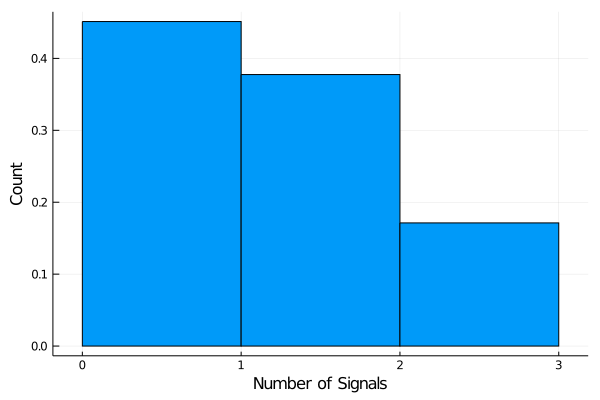

In [5]:
histogram(
    outcomes,
    bins=3,
    xlab="Number of Signals",
    ylab="Count",
    normalize=true,
    legend=false
)

Consistent with rates given in the problem, so generated data looks valid

### Model

We can model this data using a [Poisson Binomial distribution](https://en.wikipedia.org/wiki/Poisson_binomial_distribution), which is the convolution of $n$ Bernoulli distributed variables, with probability $p_1, p_2, \dots, p_n$. 

In our case, we have $n=2$ where each source omits a signal with probability $p_i$, for $i=1,2$.

Plotting generic Poisson Binomial distributions for various $p$ values:

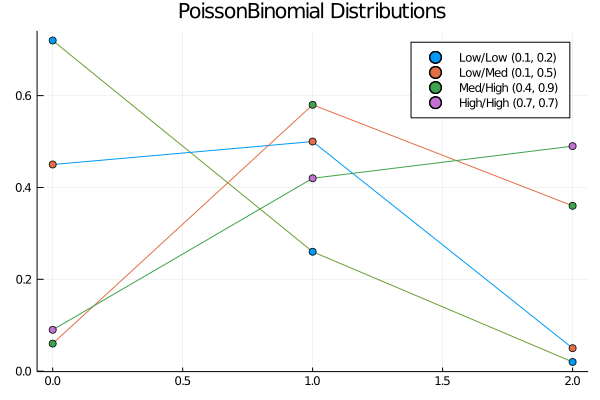

In [6]:
plot(PoissonBinomial([0.1, 0.2]),
    label="Low/Low (0.1, 0.2)",
    title="PoissonBinomial Distributions",
    legend=:best)
plot!(PoissonBinomial([0.1, 0.5]),
    label="Low/Med (0.1, 0.5)")
plot!(PoissonBinomial([0.4, 0.9]),
    label="Med/High (0.4, 0.9)")
plot!(PoissonBinomial([0.7, 0.7]),
    label="High/High (0.7, 0.7)")

We get what we would expect, a distribution bounded from 0-2. If both $p$ values are low or high, then 0 or 2 are favored. Otherwise, 1 is the most common. The distribution above shows that 0 is the most common, followed by 1, then 2, so we should expect both $p$ values to be relatively low (<0.5).

Formalizing the model is simple enough:

\begin{align*}
    y_i &~ \text{PoissonBinomial}(\mathbf{p})\\
    p_i &~ \text{Uniform}(0,1)\\
\end{align*}

Here I've claimed flat priors on $p_1$ and $p_2$. I do have a slight bias that they both should be low (mentioned above), but perhaps one is very, very low, and one is just above 0.5 - we should account for that possibility.

In [7]:
# Model Inputs
N = collect(1:length(outcomes))
y = outcomes
J = length(outcomes)

@model signals(y, J) = begin
    # Parameters
    p_a ~ Uniform(0,1)
    p_b ~ Uniform(0,1)
    
    # Model
    for i in 1:J
        y[i] ~  PoissonBinomial([p_a, p_b])
    end
end

chn = sample(signals(y, length(outcomes)), NUTS(), MCMCThreads(), 10000, 4, progress=true)
    

┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference /Users/tburch/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /Users/tburch/.julia/packages/AbstractMCMC/iOkTf/src/sample.jl:197
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/tburch/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/tburch/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
Sampling (1 threads): 100%|█████████████████████████████████████████| Time: 0:00:00


Object of type Chains, with data of type 9000×14×4 Array{Float64,3}

Iterations        = 1:9000
Thinning interval = 1
Chains            = 1, 2, 3, 4
Samples per chain = 9000
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth
parameters        = p_a, p_b

2-element Array{ChainDataFrame,1}

Summary Statistics
  parameters    mean     std  naive_se    mcse         ess   r_hat
  ──────────  ──────  ──────  ────────  ──────  ──────────  ──────
         p_a  0.3600  0.0055    0.0000  0.0000  13725.7949  1.0002
         p_b  0.3600  0.0055    0.0000  0.0000  14305.5869  1.0001

Quantiles
  parameters    2.5%   25.0%   50.0%   75.0%   97.5%
  ──────────  ──────  ──────  ──────  ──────  ──────
         p_a  0.3493  0.3563  0.3600  0.3637  0.3709
         p_b  0.3492  0.3563  0.3600  0.3637  0.3707


Our model has fit. There's no reason the model ought to prefer one $p$ over another, so it makes sense their mean and standard deviations are effectively the same. Inspecting the chains:

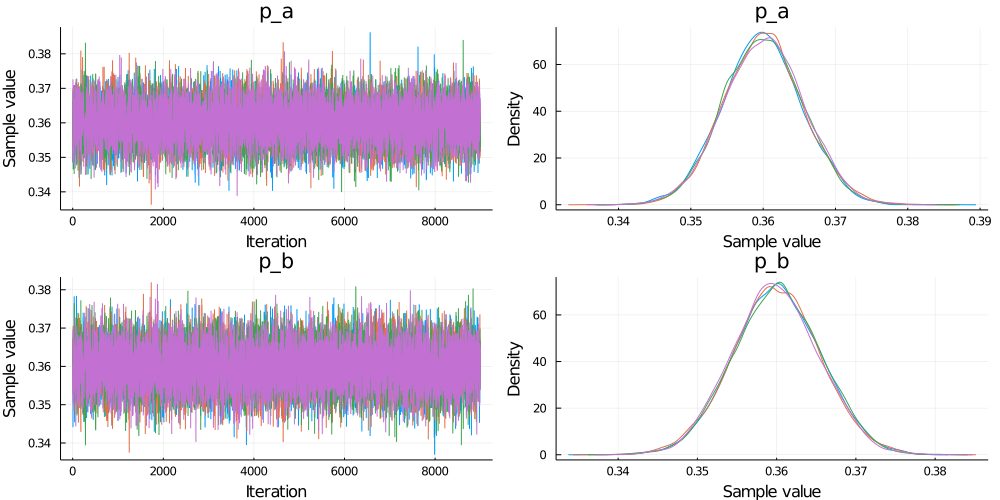

In [8]:
plot(chn)

This all looks normal, and like we have a healthy fit.

Looking at how the $p$ values covary,

In [9]:
corner(chn)

Explicitly getting the correlation:

In [10]:
p_a_vals = get(chn,:p_a)
p_b_vals = get(chn,:p_b)
round(cor(p_a_vals.p_a[:], p_b_vals.p_b[:]), digits=3)

-0.695

We can see they've got a negative correlation (-0.695), which is exactly what we'd expect - as one fluctuates up, to see the same outcome, we'd have to expect the other to fluctuate downward to arrive at this data.

### Final solution - 



Getting back to the question posed:

>Your research adviser suggests that it may just be random fluctuations from two sources. Each source had some fixed probability of emitting a signal that you picked up, and together those sources generated the pattern in your data.

>What do you think? Was it possible for your data to have come from two random fluctuations, as your adviser suggests?

This analysis shows, yes, this is definitely possible. If it were true, we would expect both sources to have about a 36% probability of emitting a signal each sampling period, with a standard deviation of 0.6%. The 95% confidence interval for these values are between 35% and 37% signal emission probability per sampling period.

### Bonus Curiosity

What are the most extreme values observed that can produce this dataset?

In [11]:
max_a = argmax(p_a_vals.p_a[:])
println(string("Most extreme p_a: ", round(p_a_vals.p_a[max_a], digits=4),
        " with corresponding p_b: ", round(p_b_vals.p_b[max_a],digits=4)))
max_b = argmax(p_b_vals.p_b[:])
println(string("Most extreme p_b: ", round(p_b_vals.p_b[max_b], digits=4), 
            " with corresponding p_a: ", round(p_a_vals.p_a[max_b],digits=4)))

Most extreme p_a: 0.3862 with corresponding p_b: 0.3433
Most extreme p_b: 0.382 with corresponding p_a: 0.3363


The $p$ with the largest difference are shown - the highest realized probability of one source is emitting per time interval is 38.2%, which corresponds to the other source emitting with a probability of 33.6%.